# Importing libraries

In [70]:
import os
import cv2
from matplotlib import pyplot as plt
import random
import pandas as pd
import numpy as np
import uuid

In [71]:
import tensorflow as tf
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Layer, Conv2D, Dense, MaxPooling2D, Input, Flatten

### setting gpu growth

In [72]:
tf.config.list_physical_devices('GPU')

[PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]

In [73]:
#setting gpu growth
gpu = tf.config.experimental.list_physical_devices('GPU')
for g in gpu:
    tf.config.experimental.set_memory_growth(g, True)

In [74]:
pospath = os.path.join('../data', 'positive')
negpath = os.path.join('../data', 'negative')
anchor = os.path.join('../data', 'anchor')

In [75]:
# os.makedirs(pospath)
# os.makedirs(negpath)
# os.makedirs(anchor)

In [76]:
# cap  = cv2.VideoCapture(0)
# while cap.isOpened():
#     ret, frame = cap.read()  
#     frame = frame[:360, :513, :]
#     cv2.imshow('image', frame)   
    
#     if cv2.waitKey(1) & 0XFF == ord('a'):
#         img = os.path.join(anchor, '{}.jpg'.format(uuid.uuid1()))
#         cv2.imwrite(img, frame)
        
#     if cv2.waitKey(1) & 0XFF == ord('p'):
#         img = os.path.join(pospath, '{}.jpg'.format(uuid.uuid1()))
#         cv2.imwrite(img, frame)
        
#     if cv2.waitKey(1) & 0XFF == ord('q'):
#         break
# cap.release()
# cv2.destroyAllWindows()    

In [77]:
# for negimg in os.listdir(negpath):
#     img = cv2.imread(os.path.join(negpath, negimg))
#     img = cv2.resize(img, None, fx=0.731, fy=0.731)
#     cv2.imwrite(os.path.join(negpath, negimg), img)

In [78]:
# img = cv2.imread(r'data\negative\000_left_ear.jpg')

In [79]:
# plt.imshow(img)

In [80]:
# for img in os.listdir(anchor):
#     a = cv2.imread(os.path.join(anchor, img))
#     a = cv2.rotate(a, cv2.ROTATE_90_CLOCKWISE)
#     cv2.imwrite(os.path.join(anchor, img), a)


In [81]:
# for directories in os.listdir("lfw"):
#     for files in os.listdir(os.path.join('lfw',directories)):
#         ex = os.path.join("lfw", directories, files)
#         new = os.path.join(negpath, files)
#         os.replace(ex, new)

In [82]:
def createdataset(path):
    return tf.data.Dataset.list_files(path+"\*.jpg").take(500) 

In [83]:
pos = createdataset(pospath)
neg = createdataset(negpath)
anch = createdataset(anchor)


In [84]:
print(pos, neg, anch, sep='\n')

<TakeDataset element_spec=TensorSpec(shape=(), dtype=tf.string, name=None)>
<TakeDataset element_spec=TensorSpec(shape=(), dtype=tf.string, name=None)>
<TakeDataset element_spec=TensorSpec(shape=(), dtype=tf.string, name=None)>


In [85]:
test = pos.as_numpy_iterator()
test.next()

b'..\\data\\positive\\741860e8-d6a1-11ed-a255-e45e37ecec6b.jpg'

In [86]:
tf.ones(len(anch))

<tf.Tensor: shape=(500,), dtype=float32, numpy=
array([1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
       1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
       1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
       1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
       1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
       1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
       1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
       1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
       1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
       1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
       1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
       1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
       1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1

In [87]:
positives = tf.data.Dataset.zip((anch, pos, tf.data.Dataset.from_tensor_slices(tf.ones(len(anch)))))
negatives = tf.data.Dataset.zip((anch, neg, tf.data.Dataset.from_tensor_slices(tf.zeros(len(anch)))))
rawdata = positives.concatenate(negatives)

In [88]:
print(positives, negatives, rawdata, sep='\n')

<ZipDataset element_spec=(TensorSpec(shape=(), dtype=tf.string, name=None), TensorSpec(shape=(), dtype=tf.string, name=None), TensorSpec(shape=(), dtype=tf.float32, name=None))>
<ZipDataset element_spec=(TensorSpec(shape=(), dtype=tf.string, name=None), TensorSpec(shape=(), dtype=tf.string, name=None), TensorSpec(shape=(), dtype=tf.float32, name=None))>
<ConcatenateDataset element_spec=(TensorSpec(shape=(), dtype=tf.string, name=None), TensorSpec(shape=(), dtype=tf.string, name=None), TensorSpec(shape=(), dtype=tf.float32, name=None))>


In [89]:
test = rawdata.as_numpy_iterator()
test.next()

(b'..\\data\\anchor\\15568b82-d6a2-11ed-ab54-e45e37ecec6b.jpg',
 b'..\\data\\positive\\b36dede3-d6a1-11ed-831f-e45e37ecec6b.jpg',
 1.0)

In [90]:
def preprocess(path):
    byteimg = tf.io.read_file(path)
    img = tf.io.decode_jpeg(byteimg)
    img = tf.image.resize(img, (105, 105))
    img /= 255.0
    return img

In [91]:
def preprocess_twin(inputimg, validationimg, label):
    return (preprocess(inputimg), preprocess(validationimg), label)

In [92]:
data = rawdata.map(preprocess_twin)
data = data.cache()
data = data.shuffle(buffer_size=1024)

In [93]:
test = data.as_numpy_iterator()
test.next()

(array([[[0.06555422, 0.09847939, 0.11002801],
         [0.05037215, 0.09395758, 0.11009204],
         [0.02963586, 0.08601841, 0.1286995 ],
         ...,
         [0.99607843, 0.99607843, 0.99607843],
         [0.99607843, 0.99607843, 0.99607843],
         [0.99607843, 0.99607843, 0.99607843]],
 
        [[0.040008  , 0.06170468, 0.07669467],
         [0.0477471 , 0.08304121, 0.10682673],
         [0.02039216, 0.06977991, 0.10616247],
         ...,
         [0.99607843, 0.99607843, 0.99607843],
         [0.99607843, 0.99607843, 0.99607843],
         [0.99607843, 0.99607843, 0.99607843]],
 
        [[0.04205682, 0.07118847, 0.10172069],
         [0.02885154, 0.07983193, 0.11120448],
         [0.01820729, 0.07414966, 0.12501001],
         ...,
         [0.99607843, 0.99607843, 0.99607843],
         [0.99607843, 0.99607843, 0.99607843],
         [0.99607843, 0.99607843, 0.99607843]],
 
        ...,
 
        [[0.20752297, 0.15178066, 0.15430167],
         [0.19619846, 0.14913964, 0.15698

In [94]:
len(data)

1000

In [95]:
train_data = data.skip(round(len(data)*.7))

In [96]:
train_data = data.take(round(len(data)*.7))
train_data = train_data.batch(16)
train_data = train_data.prefetch(8)

In [97]:
test_data = data.skip(round(len(data)*.7))
test_data = test_data.batch(16)
test_data = test_data.prefetch(8)

In [98]:
def make_embedding(): 
    inp = Input(shape=(105,105,3), name='input_image')
    
    # First block
    c1 = Conv2D(64, (10,10), activation='relu')(inp)
    m1 = MaxPooling2D(64, (2,2), padding='same')(c1)
    
    # Second block
    c2 = Conv2D(128, (7,7), activation='relu')(m1)
    m2 = MaxPooling2D(64, (2,2), padding='same')(c2)
    
    # Third block 
    c3 = Conv2D(128, (4,4), activation='relu')(m2)
    m3 = MaxPooling2D(64, (2,2), padding='same')(c3)
    
    # Final embedding block
    c4 = Conv2D(256, (4,4), activation='relu')(m3)
    f1 = Flatten()(c4)
    d1 = Dense(4096, activation='sigmoid')(f1)
    
    
    return Model(inputs=[inp], outputs=[d1], name='embedding')

In [99]:
embedding = make_embedding()
embedding.summary()

Model: "embedding"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_image (InputLayer)    [(None, 105, 105, 3)]     0         
                                                                 
 conv2d_4 (Conv2D)           (None, 96, 96, 64)        19264     
                                                                 
 max_pooling2d_3 (MaxPooling  (None, 48, 48, 64)       0         
 2D)                                                             
                                                                 
 conv2d_5 (Conv2D)           (None, 42, 42, 128)       401536    
                                                                 
 max_pooling2d_4 (MaxPooling  (None, 21, 21, 128)      0         
 2D)                                                             
                                                                 
 conv2d_6 (Conv2D)           (None, 18, 18, 128)       26

In [100]:
class L1Dist(Layer):
    def __init__(self, **kwargs):
        super().__init__()
    def call(self, input_emb, validation_emb):
        return tf.math.abs(input_emb - validation_emb)

In [101]:
inputimg = Input(name='input_img', shape=(105, 105, 3))
validationimg = Input(name='val_img', shape=(105, 105, 3))
print(inputimg, validationimg, sep='\n')

KerasTensor(type_spec=TensorSpec(shape=(None, 105, 105, 3), dtype=tf.float32, name='input_img'), name='input_img', description="created by layer 'input_img'")
KerasTensor(type_spec=TensorSpec(shape=(None, 105, 105, 3), dtype=tf.float32, name='val_img'), name='val_img', description="created by layer 'val_img'")


In [102]:
siameselayer = L1Dist()


In [103]:
inputembedding = embedding(inputimg)
validationembedding = embedding(validationimg)
print(inputembedding, validationembedding, sep='\n')

KerasTensor(type_spec=TensorSpec(shape=(None, 4096), dtype=tf.float32, name=None), name='embedding/dense_3/Sigmoid:0', description="created by layer 'embedding'")
KerasTensor(type_spec=TensorSpec(shape=(None, 4096), dtype=tf.float32, name=None), name='embedding/dense_3/Sigmoid:0', description="created by layer 'embedding'")


In [104]:
distances = siameselayer(inputembedding, validationembedding)
distances

<KerasTensor: shape=(None, 4096) dtype=float32 (created by layer 'l1_dist_2')>

In [105]:
classifier = Dense(1, activation='sigmoid')(distances)
classifier

<KerasTensor: shape=(None, 1) dtype=float32 (created by layer 'dense_4')>

In [106]:
testnetwork = Model(inputs=[inputimg, validationimg], outputs=classifier, name='SiameseNetwork')
testnetwork

In [107]:
def make_siamese_model():
    inputimg = Input(name='inputimg', shape=(105, 105, 3))
    validationimg = Input(name='validationimg', shape=(105, 105, 3))
    siameselayer = L1Dist()
    siameselayer._name = 'distance'
    distances = siameselayer(embedding(inputimg), embedding(validationimg))
    classifier = Dense(1, activation='sigmoid')(distances)
    return Model(inputs=[inputimg, validationimg], outputs=classifier, name='SiameseNetwork')
    

In [108]:
siamese_model = make_siamese_model()
siamese_model.summary()

Model: "SiameseNetwork"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 inputimg (InputLayer)          [(None, 105, 105, 3  0           []                               
                                )]                                                                
                                                                                                  
 validationimg (InputLayer)     [(None, 105, 105, 3  0           []                               
                                )]                                                                
                                                                                                  
 embedding (Functional)         (None, 4096)         38960448    ['inputimg[0][0]',               
                                                                  'validationimg[0][0

In [109]:
bcl = tf.losses.BinaryCrossentropy()
opt = tf.keras.optimizers.Adam(1e-4)

In [110]:
checkpointdir = '../checkpoints'
checkpointprefix = os.path.join(checkpointdir, 'ckpt')
checkpoint = tf.train.Checkpoint(opt=opt, siamese_model=siamese_model)

In [111]:
@tf.function
def train_step(batch):
    with tf.GradientTape() as tape:
        X = batch[:2]
        Y = batch[2]
        y_pred = siamese_model(X, training=True)
        loss = bcl(Y, y_pred)
    print(loss)
    grad = tape.gradient(loss, siamese_model.trainable_variables)
    opt.apply_gradients(zip(grad, siamese_model.trainable_variables))
    return loss

In [112]:
def train(data, EPOCHS):
    for epoch in range(1, EPOCHS+1):
        print("\n EPOCH : {}/{}".format(epoch, EPOCHS))
        progbar = tf.keras.utils.Progbar(len(data))
        
        for idx, batch in enumerate(data):
            train_step(batch)
            progbar.update(idx+1)
        if epoch%10==0:
            checkpoint.save(file_prefix=checkpointprefix)

### Accuracy

In [ ]:
EPOCHS = 50
print(train(train_data, EPOCHS))
siamese_model.save('siamese.h5')

In [114]:
model = tf.keras.models.load_model('siamese.h5', custom_objects={'L1Dist':L1Dist, 'BinaryCrossEntropy':tf.losses.BinaryCrossentropy})

In [115]:
from tensorflow.keras.metrics import Recall, Precision

In [116]:
testinput, testval, ytrue = test_data.as_numpy_iterator().next()

In [118]:
ypred = model.predict([testinput, testval])

1/1 [==============================] - 0s 124ms/step


In [119]:
[1 if prediction>0.5 else 0 for prediction in ypred]

[0, 0, 1, 0, 0, 1, 0, 0, 1, 0, 0, 1, 0, 0, 0, 1]

In [120]:
ytrue

array([0., 0., 1., 0., 0., 1., 0., 0., 1., 0., 0., 1., 0., 0., 0., 1.],
      dtype=float32)

In [121]:
m = Recall()
m.update_state(ytrue, ypred)
m.result().numpy()

1.0

In [122]:
m = Precision()
m.update_state(ytrue, ypred)
m.result().numpy()

1.0

In [124]:
r = Recall()
p = Precision()

for test_input, test_val, y_true in test_data.as_numpy_iterator():
    yhat = model.predict([test_input, test_val])
    r.update_state(y_true, yhat)
    p.update_state(y_true,yhat) 

print(r.result().numpy(), p.result().numpy())

1/1 [==============================] - 0s 22ms/step
1.0 1.0


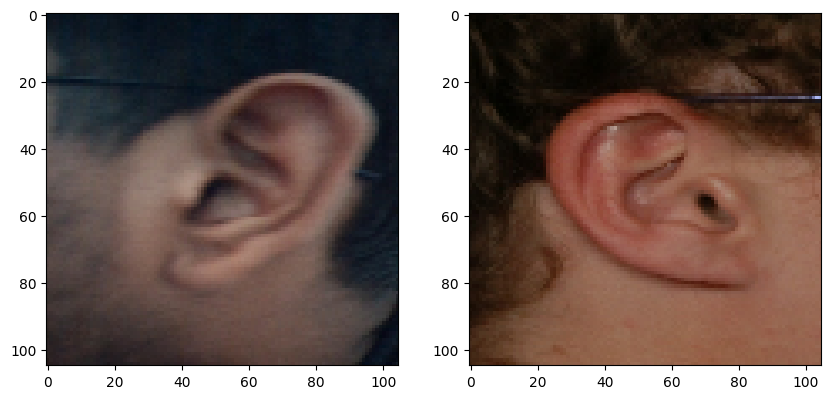

In [125]:
plt.figure(figsize=(10,8))

# Set first subplot
plt.subplot(1,2,1)
plt.imshow(testinput[0])

# Set second subplot
plt.subplot(1,2,2)
plt.imshow(testval[0])

# Renders cleanly
plt.show()